# Detecting Violent Behavior with I3D

Gluon CV is a model zoo containing a wide variety of pre-trained computer vision models, among others a useful implementation of I3D, an action detection model. This particular model is trained on Kinetics400, which, following the words of the GluonCV documentation (https://cv.gluon.ai/build/examples_action_recognition/finetune_custom.html): 

>[Kinetics400](https://deepmind.com/research/open-source/kinetics)  is an action recognition dataset
of realistic action videos, collected from YouTube. With 306,245 short trimmed videos
from 400 action categories, it is one of the largest and most widely used dataset in the research
community for benchmarking state-of-the-art video action recognition models.

The task at hand here is to fine-tune I3D on a custom dataset. This dataset contains mostly CCTV recordings, some classified with `0`, corresponding to regular, non-violent behavior, and others classified with `1`, corresponding to violent behavior which a hypothetical security agent should take into account. To carry out this fine-tuning, GluonCV's implementation using `mxnet` is employed, as it is fairly well documented and easy to use.

## 1. Environment Set-Up
Let us begin by installing and importing all necessary libraries.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install --upgrade gluoncv
!pip install gluoncv[full]
!pip3 install opencv-python

     |███████████████████████████████▌| 834.1MB 1.2MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x556026eac000 @  0x7f1e958f9615 0x555fed7e7cdc 0x555fed8c752a 0x555fed7eaafd 0x555fed8dbfed 0x555fed85e988 0x555fed8594ae 0x555fed7ec3ea 0x555fed85e7f0 0x555fed8594ae 0x555fed7ec3ea 0x555fed85b32a 0x555fed8dce36 0x555fed85a853 0x555fed8dce36 0x555fed85a853 0x555fed8dce36 0x555fed85a853 0x555fed8dce36 0x555fed85a853 0x555fed7ec30a 0x555fed85a60e 0x555fed8597ad 0x555fed7ec3ea 0x555fed85a3b5 0x555fed7ec30a 0x555fed85a3b5 0x555fed8594ae 0x555fed7ec3ea 0x555fed85b32a 0x555fed8594ae
     |████████████████████████████████| 846.0MB 21kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 1.3MB 8.2MB/s 
     |████████████████████████████████| 133kB 8.0MB/s 
     |████████████████████████████████| 337kB 42.6MB/s 
     |████████████████████████████████| 13.6MB 33.7MB/s 
 

In [ ]:
from __future__ import division

import argparse, time, logging, os, sys, math

import numpy as np
import mxnet as mx
import gluoncv as gcv
from mxnet import gluon, nd, init, context
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

from gluoncv.data.transforms import video
from gluoncv.data import VideoClsCustom
from gluoncv.model_zoo import get_model
from gluoncv.utils import makedirs, LRSequential, LRScheduler, split_and_load, TrainingHistory
from gluoncv.utils.filesystem import try_import_decord

import matplotlib.pyplot as plt
import cv2
import os
from sklearn.metrics import accuracy_score, roc_curve, RocCurveDisplay

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 2. Defining a Custom [`DataLoader`](https://github.com/dmlc/gluon-cv/blob/master/gluoncv/data/kinetics400/classification.py) to Load the Custom Dataset



GluonCV allows the user to specify the custom dataset by means of a file `train.txt`, in which the user specifies the label of each of the videos that are to be used for training. Based on this file, class `VideoClsCustom` generates a customized data loader that can be used for later fine-tuning.

In [ ]:
video_location = '/content/gdrive/MyDrive/Computer Vision Group Assignment/Computer Vision Group Assignment/Footage/Raw_Data_computer_Vision'


In [ ]:
num_gpus = 1
ctx = [mx.gpu(i) for i in range(num_gpus)]
transform_train = video.VideoGroupTrainTransform(size=(224, 224), scale_ratios=[1.0, 0.8], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
per_device_batch_size = 5
num_workers = 0
batch_size = per_device_batch_size * num_gpus

train_dataset = VideoClsCustom(root=os.path.expanduser(video_location),
                               setting=os.path.expanduser(video_location + '/train.txt'),
                               train=True,
                               new_length=32,
                               transform=transform_train,
                               video_loader=True,
                               use_decord=True)
print('Load %d training samples.' % len(train_dataset))
train_data = gluon.data.DataLoader(train_dataset, batch_size=batch_size,
                                   shuffle=True, num_workers=num_workers)

Load 30 training samples.


The same can be done with a test dataset, to be used to properly tune the model's hyperparameters.

In [ ]:
test_dataset = VideoClsCustom(root=os.path.expanduser(video_location),
                               setting=os.path.expanduser(video_location + '/test.txt'),
                               train=False,
                               new_length=32,
                               transform=transform_train,
                               video_loader=True,
                               use_decord=True)
print('Load %d testing samples.' % len(test_dataset))
test_data = gluon.data.DataLoader(test_dataset, batch_size=10,
                                   shuffle=True, num_workers=num_workers)

Load 10 testing samples.


## 3. Defining a Custom Net Architecture for Classification

The network architecture to be employed adds a single fully-connected layer to the pre-trained model. This dense layer is the one in charge of translating the action detection from within 400 categories to the particular task of detecting violent behavior.


In [ ]:
net = get_model(name='i3d_resnet50_v1_custom', nclass=2)
net.collect_params().reset_ctx(ctx)

conv2_weight is done with shape:  (64, 3, 5, 7, 7)
batchnorm2_gamma is done with shape:  (64,)
batchnorm2_beta is done with shape:  (64,)
batchnorm2_running_mean is done with shape:  (64,)
batchnorm2_running_var is done with shape:  (64,)
layer1_0_conv0_weight is done with shape:  (64, 64, 3, 1, 1)
layer1_0_batchnorm0_gamma is done with shape:  (64,)
layer1_0_batchnorm0_beta is done with shape:  (64,)
layer1_0_batchnorm0_running_mean is done with shape:  (64,)
layer1_0_batchnorm0_running_var is done with shape:  (64,)
layer1_0_conv1_weight is done with shape:  (64, 64, 1, 3, 3)
layer1_0_batchnorm1_gamma is done with shape:  (64,)
layer1_0_batchnorm1_beta is done with shape:  (64,)
layer1_0_batchnorm1_running_mean is done with shape:  (64,)
layer1_0_batchnorm1_running_var is done with shape:  (64,)
layer1_0_conv2_weight is done with shape:  (256, 64, 1, 1, 1)
layer1_0_batchnorm2_gamma is done with shape:  (256,)
layer1_0_batchnorm2_beta is done with shape:  (256,)
layer1_0_batchnorm2_ru

## 4. Training
Now that the pre-trained model has been loaded, let's proceed to prepare and carry out the fine-tuning of the additional classifier layers.

First, let's set all relevant training parameters. Note that SoftMax is used as a loss function, since this is a classifier task, and accuracy is employed as a performance metric. This last selection is valid since the classes in the custom dataset are balanced.

Note that all of these hyperparameters are selected based on their effect on the test set. A series of tuning trainings have been carried out in order to select the learning rate, its rate of decay, and the epochs at which it decays. In order to select the number of epochs for training, the point at which the accuracy of the test set diverges with respect to the accuracy of the training set is selected.

In [ ]:
# Learning rate decay factor
lr_decay = 0.1
# Epochs where learning rate decays
lr_decay_epoch = [10, 20, 30]

# Stochastic gradient descent
optimizer = 'sgd'
# Set parameters
optimizer_params = {'learning_rate': 0.005, 'wd': 0.0001, 'momentum': 0.9}

# Define our trainer for net
trainer = gluon.Trainer(net.collect_params(), optimizer, optimizer_params)

In [ ]:
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

In [ ]:
train_metric = mx.metric.Accuracy()
test_metric = mx.metric.Accuracy()
train_history = TrainingHistory(['training-acc', 'testing-acc'])

Now, let's carry out the training following the specified parameters.

In [ ]:
epochs = 8
lr_decay_count = 0
test_accuracy = []
train_accuracy = []

for epoch in range(epochs):
    tic = time.time()
    train_metric.reset()
    train_loss = 0

    # Learning rate decay
    if epoch == lr_decay_epoch[lr_decay_count]:
        trainer.set_learning_rate(trainer.learning_rate*lr_decay)
        lr_decay_count += 1

    # Loop through each batch of training data
    for i, batch in enumerate(train_data):
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        # AutoGrad
        with ag.record():
            output = []
            for _, X in enumerate(data):
                X = X.reshape((-1,) + X.shape[2:])
                pred = net(X)
                output.append(pred)
            loss = [loss_fn(yhat, y) for yhat, y in zip(output, label)]

        # Backpropagation
        for l in loss:
            l.backward()

        # Optimize
        trainer.step(batch_size)

        # Update metrics
        train_loss += sum([l.mean().asscalar() for l in loss])
        train_metric.update(label, output)

        if i == 100:
            break

    name, acc_train = train_metric.get()
    # Update history and print metrics
    train_accuracy.append(acc_train)
    print('[Epoch %d] train=%f loss=%f time: %f' %
        (epoch, acc_train, train_loss / (i+1), time.time()-tic))
    
    # Loop through each batch of test data
    for i, batch in enumerate(test_data):
        # Extract data and label
        data = split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        label = split_and_load(batch[1], ctx_list=ctx, batch_axis=0)

        output = []
        for _, X in enumerate(data):
            X = X.reshape((-1,) + X.shape[2:])
            pred = net(X)
            output.append(pred)

        test_metric.update(label, output)

    name, acc_test = test_metric.get()
    # Update history and print metrics
    test_accuracy.append(acc_test)

    train_history.update([acc_train, acc_test])

[Epoch 0] train=0.466667 loss=0.714402 time: 14.610803
[Epoch 1] train=0.733333 loss=0.544539 time: 13.665175
[Epoch 2] train=0.733333 loss=0.434229 time: 13.857138
[Epoch 3] train=0.900000 loss=0.236532 time: 14.246646
[Epoch 4] train=0.833333 loss=0.326405 time: 13.527847
[Epoch 5] train=0.966667 loss=0.110094 time: 13.089769
[Epoch 6] train=0.900000 loss=0.269472 time: 13.829254
[Epoch 7] train=0.900000 loss=0.180924 time: 13.414001


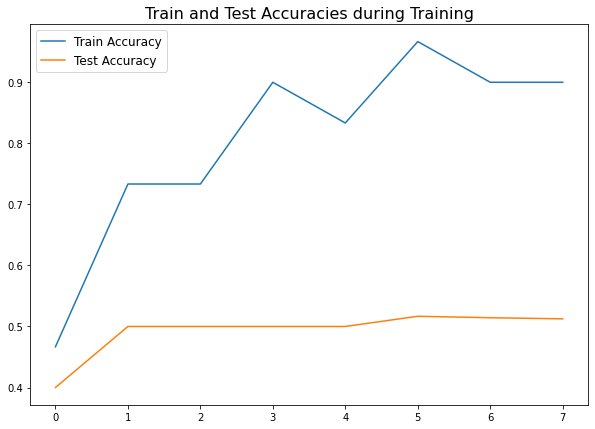

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.legend(fontsize=12)
plt.title('Train and Test Accuracies during Training', fontsize=16)
plt.show()

## 5. Model Evaluation with a Validation Set
Now that a model with an adequate set of hyperparameters has been trained, it is time to evaluate its performance on a separate validation set of videos. Thus, all we need is to load, preprocess, and predict on this new group of data samples.

In [ ]:
decord = try_import_decord()

test_folder = '/content/gdrive/MyDrive/Computer Vision Group Assignment/Computer Vision Group Assignment/Footage/Test Data/'
test_video_files = os.listdir(test_folder)

classes=["0 - Safe","1 - Violent"]
topK = 2
threshold = 0.2
predictions = []
probabilities = []
true_labels = [0, 1, 0, 1, 0, 1, 0, 1]

for file_idx in range(len(test_video_files)):
  video_fname = test_folder + test_video_files[file_idx]
  vr = decord.VideoReader(video_fname)
  frame_id_list = range(0, 64, 2)
  video_data = vr.get_batch(frame_id_list).asnumpy()
  clip_input = [video_data[vid, :, :, :] for vid, _ in enumerate(frame_id_list)]

  transform_fn = video.VideoGroupValTransform(size=(224, 224), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  clip_input = transform_fn(clip_input)
  clip_input = np.stack(clip_input, axis=0)
  clip_input = clip_input.reshape((-1,) + (32, 3, 224, 224))
  clip_input = np.transpose(clip_input, (0, 2, 1, 3, 4))
  print('Video data is readed and preprocessed.')

  # Running the prediction
  pred = net(nd.array(clip_input,  ctx = mx.gpu(0)))

  # Defining classes
  ind = nd.topk(pred, k=topK)[0].astype('int')

  # Obtaining probability and prediction
  prob_violent = nd.softmax(pred)[0][ind[1]].asscalar()
  probabilities.append(prob_violent)
  if prob_violent > threshold:
    predictions.append(1)
  else:
    predictions.append(0)
  
  print('The input video clip named '+test_video_files[file_idx]+' is classified to be')
  for i in range(topK):
    print('\t[%s], with probability %.3f.'%
          (classes[ind[i].asscalar()], nd.softmax(pred)[0][ind[i]].asscalar()))

Video data is readed and preprocessed.
The input video clip named video_001_1.mp4 is classified to be
	[0 - Safe], with probability 0.995.
	[1 - Violent], with probability 0.005.
Video data is readed and preprocessed.
The input video clip named video_002_1.mp4 is classified to be
	[0 - Safe], with probability 0.783.
	[1 - Violent], with probability 0.217.
Video data is readed and preprocessed.
The input video clip named video_003_1.mp4 is classified to be
	[0 - Safe], with probability 0.998.
	[1 - Violent], with probability 0.002.
Video data is readed and preprocessed.
The input video clip named video_004_1.mp4 is classified to be
	[1 - Violent], with probability 0.508.
	[0 - Safe], with probability 0.492.
Video data is readed and preprocessed.
The input video clip named Video_001_0.mp4 is classified to be
	[0 - Safe], with probability 0.728.
	[1 - Violent], with probability 0.272.
Video data is readed and preprocessed.
The input video clip named video_002_0.mp4 is classified to be
	[0

Now let us take a look at the model's performance based on the validation set. Since the classes in the set are balanced, it is adequate to examine the accuracy.

In [ ]:
print(f"The model's accuracy on the validation data set is {accuracy_score(true_labels, predictions) * 100:.3f}")

The model's accuracy on the validation data set is 62.500


These results are scracely better than a random guess! 
In any case, let's look at the ROC curve based on this validation set, since it is necessary to select a probability threshold to classify data samples as violent. Note that for a safe real implementation of this code, it would be preferrable to minimize false negatives at the cost of a larger amount of false posiitives.

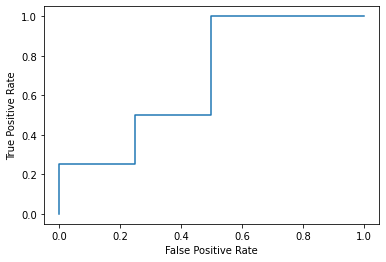

In [ ]:
fpr, tpr,_ = roc_curve(true_labels, probabilities)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

These results are not too elucidating, since the number of data samples in the validation set may be too scarce. This explains why the curve advances in a set-wise manner.

## 6. Further Work

Although the application of this model may save a lot of time and money in a successful implementation, much more needs to be explored to bring about model with a performance that makes its use viable.

In particular, the generation of an optimum dataset has been constrained by a number of factors:
*   On the one hand, the extent of this dataset has been limited by the available amount of time. Given that no standardized method for extraction of videos has been implemented, since the method varies accross particular equipments, this process proved to be somewhat time-consuming.
*   Moreover, the availability of representative data samples has also proven to be limited. Given that the main source for extracting data samples has been YouTube, it has been much easier to find CCTV recordings containing violent behavior than to find those with mundane actions. As a result, many of the data samples labelled with 'Non-Violent' come from either the few videos with such content that have been found, or from short interludes of violent recordings in which violent actions are not visible.
* Lastly, it is worth considering to what extent does the presence of multiple people in a recording, each performing a different action, hinders the model's prediction. Taking the Kinetics 400 dataset, it is possible to see that most videos show a limited number of people, all carrying out the same activity. This difference in the nature of data samples may be solvable with a more refined dataset, but may cause obstacles when acoming to a realistic application.

Some other possible areas to work on in future developments of this project involve:
* Examining how a larger dataset affects the hyperparameter selection based on the test set.
* Examining how a larger dataset affects the model's evaluation based on the validation set, as well as the selection of a probability threshold based on which to predict.
* Gaining more experience with MXNET, since many obstacles in this project have been found due to the limited knowledge of this library.
